In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as st
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statistics import mean
import ast

warnings.filterwarnings('ignore')

# Experiment 1: Measure Quality
Compare achieved standard deviation for the following settings
- Naive Repair: execute old plan, and skip steps that are not possible any more
- Replanning: 
- Replanning with Seed: 

In [206]:
def exp1_prepare_results(folder_path, visualize = False):
    files = os.listdir(os.path.join('.', folder_path))
    mean = pd.DataFrame(columns = ["Option", "Initial Plan", "STD after Disturbance", "Naive Repair", "Replanning", "Replanning (seed 0.2)"])
    std = pd.DataFrame(columns = ["Option", "Naive Repair", "Replanning", "Replanning (seed 0.2)"])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path, f))
            mean_row = {}
            std_row = {}
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_naive_2" or name == "NSGAII_NaivePlanningStrategy_2" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_naive_0"):
                    mean_row["Naive Repair"] = round(group['final_objective_value'].mean(), 3)
                    mean_row["Initial Plan"] = round(group['initial_planning_objective'].mean(), 3)
                    mean_row["STD after Disturbance"] = round(group['initial_post_disturbance_std'].mean(), 3)
                    std_row["Naive Repair"] = round(group['final_objective_value'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["final_objective_value"], label = "Naive repair")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0" or name == "NSGAII_EvaluationReplanningStrategy-10000_1" or name == "NSGAII_EvaluationReplanningStrategy-10000_0" or name == "NSGAII_PlanningStrategy-ReplanningStrategy_1"):
                    mean_row["Replanning"] = round(group['final_objective_value'].mean(), 3)
                    std_row["Replanning"] = round(group['final_objective_value'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["final_objective_value"], label = "Replan")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0,10_1" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withReinit_0" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withSeed_1" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_2"):
                    mean_row["Replanning (seed 0.2)"] = round(group['final_objective_value'].mean(), 3)
                    std_row["Replanning (seed 0.2)"] = round(group['final_objective_value'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["final_objective_value"], label = "Replan with Seed")

            mean_row["Option"] = f.split("@")[1].split("_errPerDisturbance-5")[0]
            mean = mean.append(mean_row, ignore_index = True)
            std_row["Option"] = f.split("@")[1].split("_errPerDisturbance-5")[0]
            std = std.append(std_row, ignore_index = True)
            if visualize:
                plt.title(f.split("@")[1].split("_errPerDisturbance-5")[0])
                plt.legend()
                plt.show()
    return (mean, std)
    
def exp1_relative_values(absolute_values):
    mean_relative = pd.DataFrame(columns = ["Option", "Diff STD after disturbance to initial plan", "Diff Naive Repair to Initial", 
                                           "Diff Replanning to Naive Repair", "Diff seed 0.2 to no seed"])
    mean_relative["Diff STD after disturbance to initial plan"] = (absolute_values["STD after Disturbance"] - absolute_values["Initial Plan"]) / absolute_values["Initial Plan"] * 100
    mean_relative["Diff Naive Repair to Initial"] = (absolute_values["Naive Repair"] - absolute_values["Initial Plan"]) / absolute_values["Initial Plan"] * 100
    mean_relative["Diff Replanning to Naive Repair"] = (absolute_values["Replanning"] - absolute_values["Naive Repair"])/ absolute_values["Naive Repair"] * 100
    mean_relative["Diff seed 0.2 to no seed"] = (absolute_values["Replanning (seed 0.2)"] - absolute_values["Replanning"])/ absolute_values["Replanning"] * 100
    mean_relative["Option"] = absolute_values["Option"]
    mean_relative.round(3)
    return mean_relative

## fixed plan length (solutionLength = 200)

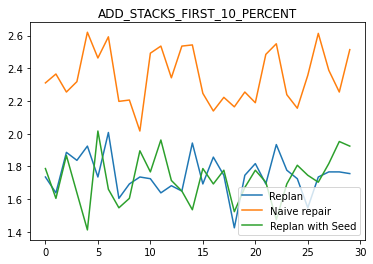

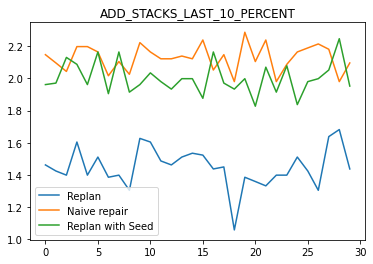

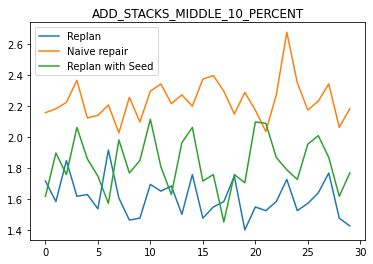

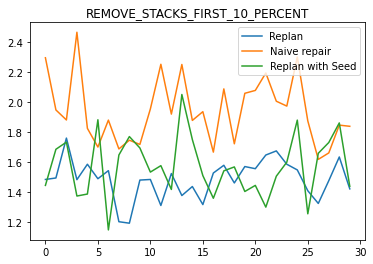

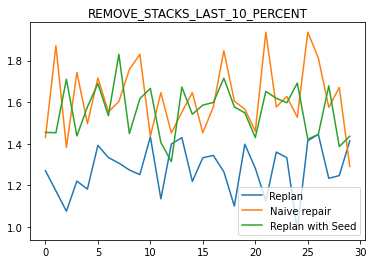

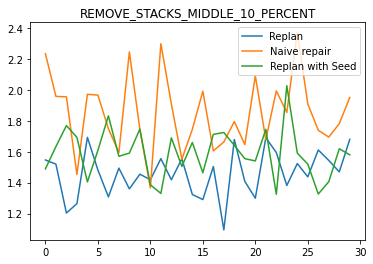

Simple Model


,Option,Diff STD after disturbance to initial plan,Diff Naive Repair to Initial,Diff Replanning to Naive Repair,Diff seed 0.2 to no seed
0,ADD_STACKS_FIRST_10_PERCENT,95.220811,42.286751,-25.722789,-1.316543
1,ADD_STACKS_LAST_10_PERCENT,14.444444,31.358025,-31.907895,38.164251
2,ADD_STACKS_MIDDLE_10_PERCENT,72.710623,36.507937,-28.175313,13.760897
3,REMOVE_STACKS_FIRST_10_PERCENT,95.930949,19.667078,-23.493045,5.791246
4,REMOVE_STACKS_LAST_10_PERCENT,16.814159,2.338812,-21.000618,21.813917
5,REMOVE_STACKS_MIDDLE_10_PERCENT,73.841463,12.804878,-21.081081,8.835616


Complex Model


,Option,Diff STD after disturbance to initial plan,Diff Naive Repair to Initial,Diff Replanning to Naive Repair,Diff seed 0.2 to no seed
0,ADD_STACKS_FIRST_10_PERCENT,83.998682,44.519104,-30.052876,5.109156
1,ADD_STACKS_LAST_10_PERCENT,12.306345,36.817998,-33.635289,40.393175
2,ADD_STACKS_MIDDLE_10_PERCENT,72.203052,42.435302,-32.834847,10.876049
3,REMOVE_STACKS_FIRST_10_PERCENT,84.654055,19.638841,-21.755957,-3.066704
4,REMOVE_STACKS_LAST_10_PERCENT,13.345028,1.673189,-21.439947,16.006419
5,REMOVE_STACKS_MIDDLE_10_PERCENT,72.189586,12.216288,-21.189768,1.683273


In [214]:
exp1_mean_simpleModel, exp1_std_simpleModel = exp1_prepare_results("exp1/fixedPlanLength/max10itemsperstack", True)
exp1_mean_simpleModel = exp1_relative_values(exp1_mean_simpleModel)
exp1_mean_complexModel, exp1_std_complexModel = exp1_prepare_results("exp1/fixedPlanLength/max100itemsperstack")
exp1_mean_complexModel = exp1_relative_values(exp1_mean_complexModel)
print("Simple Model")
display(exp1_mean_simpleModel)
print("Complex Model")
display(exp1_mean_complexModel)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

## Statistical Testing

In [208]:
def test(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    naive_repair = []
    replan = []
    replan_seed = []
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path, f))
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_naive_2" or name == "NSGAII_NaivePlanningStrategy_2" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_naive_0"):
                       naive_repair+=(group['final_objective_value'].tolist())
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0" or name == "NSGAII_EvaluationReplanningStrategy-10000_1" or name == "NSGAII_EvaluationReplanningStrategy-10000_0" or name == "NSGAII_PlanningStrategy-ReplanningStrategy_1"):
                       replan+=(group['final_objective_value'].tolist())
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0,10_1" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withReinit_0" or name == "NSGAII_EvaluationReplanningStrategy-10000reusePortion=0.2_withSeed_1" or name =="NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_2"):
                       replan_seed+=(group['final_objective_value'].tolist())
    print("1. Hypothesis: objective value of replan < objective value of repair")
    print(st.mannwhitneyu(replan, naive_repair, alternative="less"))
    print("2. Hypothesis: objective value of replan < objective value of replan with seed")
    print(st.mannwhitneyu(replan, replan_seed, alternative="less"))
    print("3. Hypothesis: objective value of repair = objective value of replan with seed")
    print(st.mannwhitneyu(naive_repair, replan_seed, alternative="two-sided"))
    
print("Simple Model")
test("exp1/fixedPlanLength/max10itemsperstack")
print("Complex Model")
test("exp1/fixedPlanLength/max100itemsperstack")

Simple Model
1. Hypothesis: objective value of replan < quality of repair
MannwhitneyuResult(statistic=2801.5, pvalue=2.979717860796967e-42)
2. Hypothesis: objective value of replan < quality of replan with seed
MannwhitneyuResult(statistic=8022.5, pvalue=6.027289256868134e-17)
3. Hypothesis: objective value of repair = quality of replan with seed
MannwhitneyuResult(statistic=25515.0, pvalue=3.919249600882078e-21)
Complex Model
1. Hypothesis: objective value of replan < quality of repair
MannwhitneyuResult(statistic=645.0, pvalue=1.0170515105119843e-22)
2. Hypothesis: objective value of replan < quality of replan with seed
MannwhitneyuResult(statistic=3332.0, pvalue=0.020049637178710528)
3. Hypothesis: objective value of repair = quality of replan with seed
MannwhitneyuResult(statistic=7245.0, pvalue=6.287273025193989e-20)


# Experiment 2: Measurement of Evaluations/Time
### Predefined standard deviation ( >= 50% decrease from initial std); Search until quality is sufficient (for initial plan & when replanning after disturbance)


In [17]:
def exp2_prepare_results(folder_path, visualize=False):
    files = os.listdir(os.path.join('.', folder_path))
    mean = pd.DataFrame(columns = ["Option", "Replanning", "Replanning (seed 0.2)", "Diff to no seed"])
    std = pd.DataFrame(columns = ["Option", "Replanning", "Replanning (seed 0.2)"])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            mean_row = {}
            std_row = {}
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0"):
                    mean_row["Replanning"] = round(group['last_replanning_time'].median(), 3)
                    std_row["Replanning"] = round(group['last_replanning_time'].std(), 3)
                    if visualize:
                        plt.plot(group["run"], group["last_replanning_time"], label = "Replanning")
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"):
                    mean_row["Replanning (seed 0.2)"] = round(group['last_replanning_time'].median(), 3)
                    std_row["Replanning (seed 0.2)"] = round(group['last_replanning_time'].std(), 3)
                    if visualize:
                        plt.plot(group["run"],group["last_replanning_time"],  label = "Replanning with Seed")
            #print(f)"NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1" und "NSGAII_PlanningStrategy-ReplanningStrategy_0"
           # print(mean_row)
            mean_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
            mean = mean.append(mean_row, ignore_index = True)
            std_row["Option"] = f.split("@")[1].split(".")[0]
            std = std.append(std_row, ignore_index = True)
            if visualize:
                plt.title(f.split("@")[1].split("_errPerDisturbance")[0])
                plt.legend()
                plt.show()
    print("Median - Replanning time")
    mean["Diff to no seed"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"]) / mean["Replanning"] * 100
    return (mean, std)

def visualize(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            plt.plot(df["last_replanning_evaluations"])
            plt.title(f.split("@")[1].split("_errPerDisturbance")[0])
            plt.show()

## fixed plan length (solutionLength = 200)

Median - Replanning time


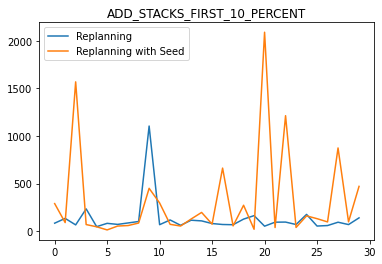

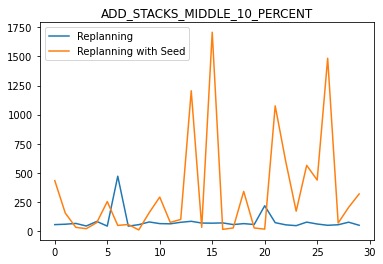

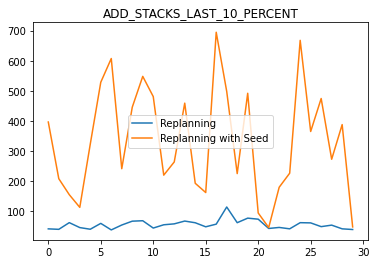

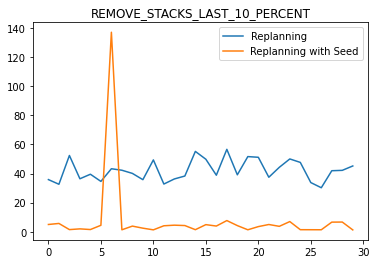

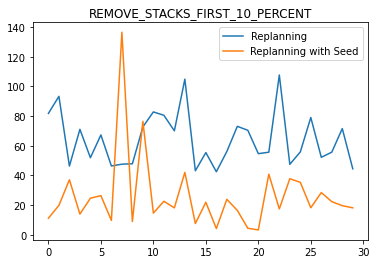

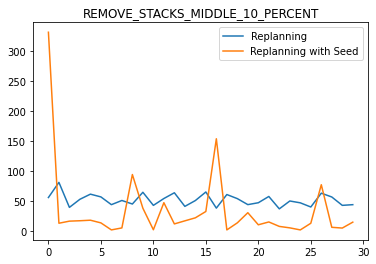

Median - Replanning time


,Option,Replanning,Replanning (seed 0.2),Diff to no seed
0,ADD_STACKS_FIRST_10_PERCENT,84.619,97.161,14.82173
1,ADD_STACKS_MIDDLE_10_PERCENT,64.416,157.806,144.979508
2,ADD_STACKS_LAST_10_PERCENT,54.77,298.016,444.122695
3,REMOVE_STACKS_LAST_10_PERCENT,40.989,3.934,-90.402303
4,REMOVE_STACKS_FIRST_10_PERCENT,55.921,19.651,-64.859355
5,REMOVE_STACKS_MIDDLE_10_PERCENT,50.378,13.662,-72.881019


In [18]:
exp2_mean_simpleModel, exp2_std_simpleModel = exp2_prepare_results("exp2/fixedPlanLength/max10itemsperstack")
exp2_mean_complexModel, exp2_std_complexModel = exp2_prepare_results("exp2/fixedPlanLength/max100itemsperstack", True)
display(exp2_mean_complexModel)

## statistical testing

In [5]:
def get_data(folder_path):
    files = os.listdir(os.path.join('.', folder_path))
    replan = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    seed = pd.DataFrame(columns = ['Disturbance', 'Setting', 'Value'])
    for f in files:
        if f.endswith("csv"):
            df = pd.read_csv(os.path.join('.', folder_path,f), sep=",")
            option = f.split("@")[1].split("_errPerDisturbance")[0]
            disturbance = option.split("_")[0]
            setting = option.split("_")[2]
            for name, group in df.groupby(by='variant'):
                if(name == "NSGAII_PlanningStrategy-ReplanningStrategy_0"):
                    for index, row in group.iterrows():
                        replan = replan.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['last_replanning_evaluations']},
                                         ignore_index=True)
                elif(name == "NSGAII_PlanningStrategy-ReplanningStrategy_reuse0.10_1"):
                    for index, row in group.iterrows():
                        seed = seed.append({'Disturbance': disturbance, 'Setting': setting, 'Value': row['last_replanning_evaluations']},
                                         ignore_index=True)
    return (replan, seed)
                    
replan_large, seed_large = get_data("exp2/fixedPlanLength/max100itemsperstack")
replan_small, seed_small = get_data("exp2/fixedPlanLength/max10itemsperstack")


In [20]:
def test(replan, seed):
    p_values = pd.DataFrame(columns = ["Option", "p-value"])
    row = {}
    row['Option'] = "First 10 %"
    x = seed[seed.Setting == "FIRST"]['Value'].tolist()
    y = replan[replan.Setting == "FIRST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Middle 10 %"
    x = seed[seed.Setting == "MIDDLE"]['Value'].tolist()
    y = replan[replan.Setting == "MIDDLE"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    row['Option'] = "Last 10 %"
    x = seed[seed.Setting == "LAST"]['Value'].tolist()
    y = replan[replan.Setting == "LAST"]['Value'].tolist()
    row['p-value'] = st.mannwhitneyu(x, y, alternative="greater")[1]
    p_values = p_values.append(row, ignore_index = True)
    return p_values
print("Large Model - Add Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='ADD']
seed_large_add = seed_large[seed_large.Disturbance=='ADD']
display(test(replan_large_add, seed_large_add))
print("Large Model - Delete Stack Case")
replan_large_add = replan_large[replan_large.Disturbance=='REMOVE']
seed_large_add = seed_large[seed_large.Disturbance=='REMOVE']
display(test(replan_large_add, seed_large_add))
print("Small Model - Add Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='ADD']
seed_small_add = seed_small[seed_small.Disturbance=='ADD']
display(test(replan_small_add, seed_small_add))
print("Small Model - Delete Stack Case")
replan_small_add = replan_small[replan_small.Disturbance=='REMOVE']
seed_small_add = seed_small[seed_small.Disturbance=='REMOVE']
display(test(replan_small_add, seed_small_add))

Large Model - Add Stack Case


,Option,p-value
0,First 10 %,0.001553
1,Middle 10 %,0.000002
2,Last 10 %,0.0


Large Model - Delete Stack Case


,Option,p-value
0,First 10 %,0.999722
1,Middle 10 %,0.5
2,Last 10 %,0.999993


Small Model - Add Stack Case


,Option,p-value
0,First 10 %,0.003334
1,Middle 10 %,0.000014
2,Last 10 %,0.0


Small Model - Delete Stack Case


,Option,p-value
0,First 10 %,0.774609
1,Middle 10 %,0.914317
2,Last 10 %,0.999967


# Experiment 3: Parallel Replanning
### Predefined standard deviation ( >= 50% decrease from initial std + initialization approximate); Search until quality is sufficient (initial plan & replan after disturbance while system idle), search in parallel until Q1 = Q2 and T1 < T2

## 1. Case: Evaluatie Time (seconds')

1to100_steps1to10_DISTURBER@ADD_STACKS_FIRST_10_PERCENT_errPerDisturbance-5.csv


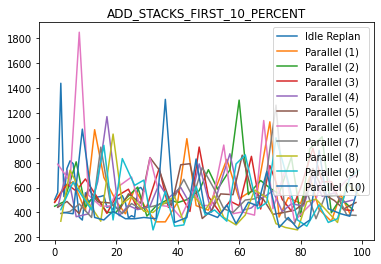

1to100_steps1to10_DISTURBER@ADD_STACKS_MIDDLE_10_PERCENT_errPerDisturbance-5.csv


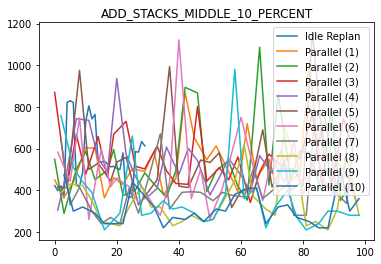

50stacks_1to_100_predictive2_5_10_DISTURBER@ADD_STACKS_FIRST_10_PERCENT_errPerDisturbance-5.csv


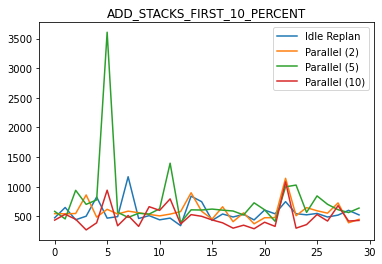

50stacks_1to_100_predictive2_5_10_DISTURBER@ADD_STACKS_MIDDLE_10_PERCENT_errPerDisturbance-5.csv


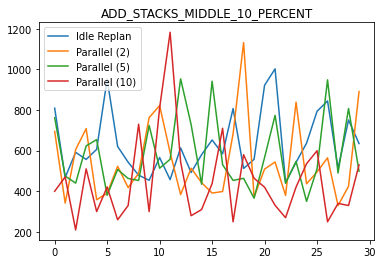

50stacks_1to_100_predictive2_5_10_DISTURBER@REMOVE_STACKS_FIRST_10_PERCENT_errPerDisturbance-5.csv


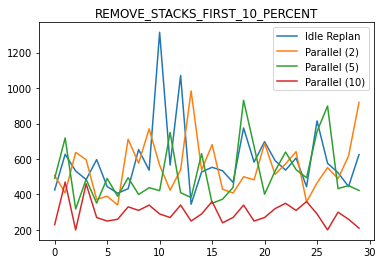

50stacks_1to_100_predictive2_5_10_DISTURBER@REMOVE_STACKS_MIDDLE_10_PERCENT_errPerDisturbance-5.csv


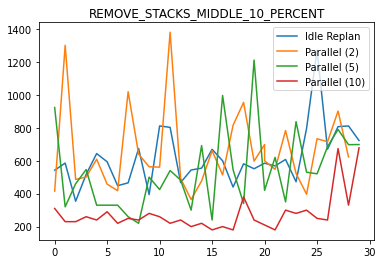

Median - Execution time (seconds)


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10),Parallel (1),Parallel (3),Parallel (4),Parallel (6),Parallel (7),Parallel (8),Parallel (9)
0,ADD_STACKS_FIRST_10_PERCENT,519.943,526.336,486.634,380.026,500.042,522.056,490.746,523.571,470.952,451.711,471.225
1,ADD_STACKS_MIDDLE_10_PERCENT,529.753,488.621,447.262,300.098,497.042,516.532,487.451,440.106,385.106,320.070,300.173


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10),Parallel (1),Parallel (3),Parallel (4),Parallel (6),Parallel (7),Parallel (8),Parallel (9)
2,ADD_STACKS_FIRST_10_PERCENT,521.915,545.965,609.744,425.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADD_STACKS_MIDDLE_10_PERCENT,588.101,502.324,512.091,420.587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,REMOVE_STACKS_FIRST_10_PERCENT,545.351,538.186,467.768,290.092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,REMOVE_STACKS_MIDDLE_10_PERCENT,585.096,598.23,510.206,240.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Median - Execution time relative to idle replanning (%)


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10),Parallel (1),Parallel (3),Parallel (4),Parallel (6),Parallel (7),Parallel (8),Parallel (9)
0,ADD_STACKS_FIRST_10_PERCENT,519.943,1.229558,-6.406279,-26.910065,500.042,522.056,490.746,523.571,470.952,451.711,471.225
1,ADD_STACKS_MIDDLE_10_PERCENT,529.753,-7.764373,-15.571597,-43.351335,497.042,516.532,487.451,440.106,385.106,320.070,300.173


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10),Parallel (1),Parallel (3),Parallel (4),Parallel (6),Parallel (7),Parallel (8),Parallel (9)
2,ADD_STACKS_FIRST_10_PERCENT,521.915,4.60803,16.828219,-18.541142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADD_STACKS_MIDDLE_10_PERCENT,588.101,-14.58542,-12.924651,-28.483883,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,REMOVE_STACKS_FIRST_10_PERCENT,545.351,-1.313833,-14.226251,-46.806369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,REMOVE_STACKS_MIDDLE_10_PERCENT,585.096,2.24476,-12.799609,-58.961435,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Standard Deviation - Execution time (seconds)


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10),Parallel (1),Parallel (3),Parallel (4),Parallel (6),Parallel (7),Parallel (8),Parallel (9)
0,ADD_STACKS_FIRST_10_PERCENT,39.244109,40.231525,29.778437,64.979765,41.719696,29.677276,35.359636,57.412844,40.519416,34.675047,44.749111
1,ADD_STACKS_MIDDLE_10_PERCENT,28.28035,38.549714,43.69117,25.722597,29.152466,25.354286,29.768736,39.800412,40.041183,38.845253,57.126057


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10),Parallel (1),Parallel (3),Parallel (4),Parallel (6),Parallel (7),Parallel (8),Parallel (9)
2,ADD_STACKS_FIRST_10_PERCENT,31.15948,28.89013,94.376984,44.945266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADD_STACKS_MIDDLE_10_PERCENT,26.516194,38.470589,34.026179,49.124676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,REMOVE_STACKS_FIRST_10_PERCENT,36.016254,28.628207,34.489533,22.299822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,REMOVE_STACKS_MIDDLE_10_PERCENT,30.208547,41.244672,47.131943,49.538763,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
T = 10
plot = True
files = os.listdir(os.path.join('.', 'exp3/case_1to100'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (2)", "Parallel (5)", "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan",  "Parallel (2)", "Parallel (5)", "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3/case_1to100', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3/case_1to100', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        print(f)
        df_p['run'] = df_p['run'].map(int)/3
        df_p['run'] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"] + df["last_replanning_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1]*T for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =  df_p["pred_plan_steps_execution_time"] + df_p["pred_plan_runtime"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            if plot:
                plt.plot(g["run"], g["overall_execution_time"], label = "Idle Replan")
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
            if plot:
                plt.plot(group["run"], group["pred_overall_execution_time"], label=f"Parallel ({name[1]})")
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)
        if plot:
            plt.legend()
            plt.title(mean_executiontime_row["Option"])
            plt.show()
        
print("Median - Execution time (seconds)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Execution time relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Execution time (seconds)")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])


In [203]:
display(overall_runtime.loc[:2, 'Parallel (1)'])

0    500.042
1    497.042
2        NaN
Name: Parallel (1), dtype: float64

## 2. Case: Compare ONLY execution steps of new plan

In [55]:
T = 10
files = os.listdir(os.path.join('.', 'exp3'))
overall_runtime = pd.DataFrame(columns = ["Option", "Idle Replan", "Parallel (2)", "Parallel (5)", "Parallel (10)"])
overall_runtime_std = pd.DataFrame(columns =  ["Option", "Idle Replan",  "Parallel (2)", "Parallel (5)", "Parallel (10)"])
for f in files:
    if f.endswith("csv"):
        df = pd.read_csv(os.path.join('.', 'exp3', f), sep=";")
        df_p = pd.read_csv(os.path.join('.', 'exp3', "parallel_results", f[:-4] + "_predictive.csv"), sep=";")
        
        ## reenumerate predictive run rows from 0,1,2,3,4,5 to 0,0,0, 1,1,1, ...
        df_p['run'] = df_p['run'].map(int)/3
        df_p["run"] = df_p["run"].map(int)
        
        step_variants = df_p["predicted_steps"].unique()
        
        ## get idle computed objs from predictive run file
        idle_computed_objs = []
        for idx, row in df.iterrows():
            #if not df_p.loc[df_p["run"] == row['run']].empty:
                #idle_computed_objs
                #print(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
            idle_computed_objs.append(df_p.loc[df_p["run"] == row['run']].iloc[0]["idle_computed_objectives"])
 
        df["idle_computed_objectives"] = idle_computed_objs
        df["idle_computed_steps"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["idle_computed_steps_execution_time"] = [ast.literal_eval(g)[1] for g in idle_computed_objs]
        df["overall_execution_time"] =  df["idle_computed_steps_execution_time"]
       # print(df)
        mean_executiontime_row = {}
        std_executiontime_row = {}

        df_p["pred_plan_steps"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_plan_steps_execution_time"] = [ast.literal_eval(g)[1] for g in df_p["pred_plan_objectives"]]
        df_p["pred_overall_execution_time"] =   df_p["pred_plan_steps_execution_time"]

        for name, g in df.groupby(by='variant'):
            mean_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].median(),3)
            std_executiontime_row["Idle Replan"] = round(g['overall_execution_time'].std(),3)/mean_executiontime_row["Idle Replan"]*100            
            
        for name, group in df_p.groupby(by=['variant', 'predicted_steps']):
            mean_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].median(), 3)
            std_executiontime_row[f"Parallel ({name[1]})"] = round(group['pred_overall_execution_time'].std(), 3)/mean_executiontime_row[f"Parallel ({name[1]})"]*100
   
      
        mean_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        std_executiontime_row["Option"] = f.split("@")[1].split("_errPerDisturbance")[0]
        overall_runtime = overall_runtime.append(mean_executiontime_row, ignore_index = True)
        overall_runtime_std = overall_runtime_std.append(std_executiontime_row, ignore_index = True)

        
print("Median - Number of Evaluations")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

for steps in step_variants:
    overall_runtime[f"Parallel ({steps})"] = (overall_runtime[f"Parallel ({steps})"] - overall_runtime["Idle Replan"])/ overall_runtime["Idle Replan"] * 100

#mean.round({'Replanning': 1})
#mean["Replanning (seed 0.2)"] = (mean["Replanning (seed 0.2)"] - mean["Replanning"])/ mean["Replanning"] * 100
#mean.round(3)
#print("Mean - Replanning time (with seed) relative to plain replanning (in %)")
print("Median - Number of Evaluations relative to idle replanning (%)")
display(overall_runtime.iloc[:2, :])
display(overall_runtime.iloc[2:, :])

print("Standard Deviation - Number of Evaluations")
#overall_runtime_std.iloc[:, 1:] = overall_runtime_std[:, 1:]/overall_runtime[:, 1:]


display(overall_runtime_std.iloc[:2, :])
display(overall_runtime_std.iloc[2:, :])
# todo: create table for each rq
# todo: create plot for each rq

# todo: in den CSVs: naive Planning -> naive Repair

Median - Number of Evaluations


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,41.5,45.5,51.0,32.0
1,ADD_STACKS_MIDDLE_10_PERCENT,48.0,41.0,42.5,28.0


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
2,REMOVE_STACKS_FIRST_10_PERCENT,49.5,47.0,40.0,19.0
3,REMOVE_STACKS_MIDDLE_10_PERCENT,53.0,53.0,44.0,14.0


Median - Number of Evaluations relative to idle replanning (%)


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,41.5,9.638554,22.891566,-22.891566
1,ADD_STACKS_MIDDLE_10_PERCENT,48.0,-14.583333,-11.458333,-41.666667


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
2,REMOVE_STACKS_FIRST_10_PERCENT,49.5,-5.050505,-19.191919,-61.616162
3,REMOVE_STACKS_MIDDLE_10_PERCENT,53.0,0.0,-16.981132,-73.584906


Standard Deviation - Number of Evaluations


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
0,ADD_STACKS_FIRST_10_PERCENT,38.024096,25.358242,38.988235,46.31875
1,ADD_STACKS_MIDDLE_10_PERCENT,32.945833,45.763415,38.675294,72.142857


,Option,Idle Replan,Parallel (2),Parallel (5),Parallel (10)
2,REMOVE_STACKS_FIRST_10_PERCENT,38.925253,33.546809,39.63,34.036842
3,REMOVE_STACKS_MIDDLE_10_PERCENT,31.175472,45.532075,52.463636,74.021429
